# Offshore wave analysis

This Jupyter notebook is dedicated to analyse the long-term wave climate offshore Phu Yen province, Central Vietnam. 
The raw data is retrieved from a reanalysed wave repository by Mr Nguyễn Thành Luân (Researcher - Hydraulic, River and Coastal Engineering (Vietnam Academy for Water Rersources)). The data file `'wavedata.txt'` (88,864 records, not included here) spans from 1989 to 2018 (30 years). The time sampling frequency is 3 hours. The wave characteristics obtained are:
* Significant wave height `Hs` (in m), with a precision of whole cm,
* Peak wave period `Tp` [s], with a precision of 0.01 s,
* Main wave direction `Dir` [°], in the nautical system (north = 0°, east = 90°).

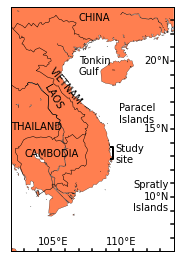

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from mpl_toolkits.basemap import Basemap

# set up cylindrical map projection [cyl] (other options: ortho, etc.)
# with perspective of satellite looking down at 50N, 100W.
# use high resolution coastlines. Other options: c, l, m, h, f.
# area threshold suppresses islands with area less than the value 

plt.figure(figsize=(3, 4.5))

MIN_LON = 102
MAX_LON = 114
MIN_LAT = 6
MAX_LAT = 24

map = Basemap(projection='cyl',lon_0=110,lat_0=12.5,resolution='l', area_thresh = 0.1,\
    llcrnrlon=MIN_LON, llcrnrlat=MIN_LAT,\
    urcrnrlon=MAX_LON, urcrnrlat=MAX_LAT)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.5)
map.fillcontinents(color='coral',lake_color='white')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='white')
#map.drawmeridians(np.arange(105.5,105.8,0.1))
#map.drawparallels(np.arange(18.85,19.15,0.1))

plt.annotate('CHINA', xy=(107, 23))
plt.annotate('LAOS', xy=(104.3, 16.5)).set_rotation(-60)
plt.annotate('CAMBODIA', xy=(103, 13))
plt.annotate('THAILAND', xy=(102, 15))
plt.annotate('VIETNAM', xy=(104.7, 16.8)).set_rotation(-50)

plt.annotate('Tonkin\nGulf', xy=(107, 19))
plt.annotate('Paracel\nIslands', xy=(110, 15.5))
plt.annotate('Spratly\n\nIslands', xy=(111, 9))

# Study site - Phu Yen
x_site = [109.4, 109.5, 109.5, 109.4]
y_site = [12.8, 12.8, 13.7, 13.7]
plt.plot(x_site, y_site, color='k', linestyle='-', linewidth=2)  
plt.annotate('Study\nsite', xy=(109.7, 12.5))

for lon_ticks in range(103, 114):
    plt.plot([lon_ticks, lon_ticks], [6, 6.2], color='k', linestyle='-') # tick
    if lon_ticks % 5 == 0:
        plt.annotate('%i°E' % lon_ticks, xy=(lon_ticks - 1, MIN_LAT + 0.5))

for lat_ticks in range(7, 24):
    plt.plot([113.8, 114], [lat_ticks, lat_ticks], color='k', linestyle='-') # tick
    if lat_ticks % 5 == 0:
        plt.annotate('%i°N' % lat_ticks, xy=(MAX_LON - 2.2, lat_ticks - 0.2))

plt.savefig('map.pdf')

In [2]:
table = pd.read_csv('wavedata.txt', delim_whitespace=True)

The followings are the beginning and end parts of the dataset.

In [3]:
table.head()

,year,month,day,hour,Hs,Tp,Dir
0,1989,1,1,0,2.59,9.32,41.65
1,1989,1,1,3,2.73,9.03,40.41
2,1989,1,1,6,2.78,9.06,40.27
3,1989,1,1,9,2.91,9.04,40.55
4,1989,1,1,12,3.01,9.05,41.56


In [46]:
table.tail()

,year,month,day,hour,Hs,Tp,Dir
88859,2019,5,31,9,0.61,8.03,43.01
88860,2019,5,31,12,0.68,7.89,42.48
88861,2019,5,31,15,0.72,7.78,42.55
88862,2019,5,31,18,0.72,7.67,42.83
88863,2019,5,31,21,0.69,7.50,42.97


To create an "integrated" date column:

In [3]:
table['datetime'] = table.apply(lambda row: 
                                datetime.datetime(int(row.year), int(row.month), int(row.day), int(row.hour)), 
                                axis=1)

The wave height time series:

/Volumes/W10/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


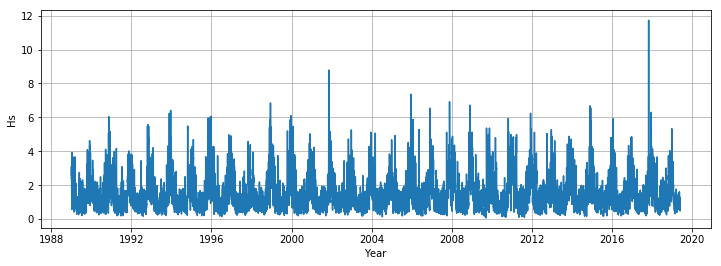

In [5]:
plt.figure(figsize=(12,4))
plt.plot(table['datetime'], table['Hs'])
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Hs')
plt.savefig('Hs_timeseries.png')

## Wave energy density
Following the formula:

$$ E = \frac{1}{8} \rho g H^2 $$

where $\rho$ = 1025 kg/m<sup>3</sup>, g = 9.81 m/s<sup>2</sup>.

In [4]:
table['Energy'] = table.apply(lambda row: 0.125*1025*9.81* row.Hs**2, axis=1)

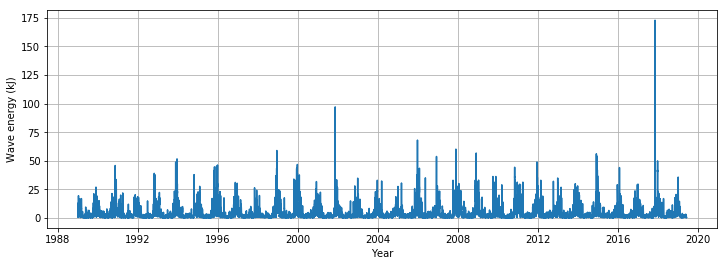

In [7]:
plt.figure(figsize=(12,4))
plt.plot(table['datetime'], table['Energy']/1000)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Wave energy (kJ)')
plt.savefig('Energy_timeseries.png')

Some statistics of the wave energy density [J].

In [8]:
table['Energy'].describe()

count     88864.000000
mean       3614.979561
std        5427.638177
min           6.158841
25%         707.009766
50%        1576.663200
75%        4072.376250
max      172941.375966
Name: Energy, dtype: float64

## Summarise by month

Create an auxiliary column:

In [5]:
table['yearmonth'] = table.apply(lambda row: str(row.year) + "-" + "{:02d}".format(row.month),
                                 axis=1)

Aggregating for monthly wave energy:

In [6]:
tableEmonthly = pd.pivot_table(table, index=['yearmonth'], values='Energy', aggfunc=np.average)
tableEmonthly.head()

,Energy
yearmonth,
1989-01,6575.710308
1989-02,4715.630568
1989-03,3614.516219
1989-04,853.330412
1989-05,1572.791625


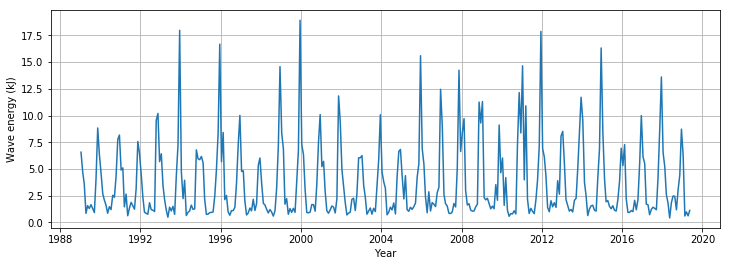

In [16]:
plt.figure(figsize=(12,4))
plt.plot(tableEmonthly['Energy']/1000)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Wave energy (kJ)')
plt.savefig('monthly_Energy_timeseries.png')

In [17]:
tableEmonthly['Energy'].describe()

count      365.000000
mean      3611.581884
std       3452.371265
min        426.376557
25%       1175.392839
50%       2118.215956
75%       5222.529600
max      18918.178459
Name: Energy, dtype: float64

## Summarise by year

In [7]:
tableEyearly = pd.pivot_table(table, index=['year'], values='Energy', aggfunc=np.average)
tableEyearly.drop([2019], axis=0, inplace=True) # năm 2019 thiếu số liệu, chỉ đến hết tháng 5.
Eyr_avg = float(tableEyearly.mean())
Eyr_avg

3637.881845427817

In [38]:
tableEyearly[tableEyearly['Energy'] > Eyr_avg]

,Energy
year,
1993,4025.740336
1995,4229.770527
1996,3742.100952
1999,4493.390644
2000,3768.130974
2001,3682.440714
2005,3731.304150
2007,3909.062977
2008,4268.899380


In [40]:
tableEyearly.describe()

,Energy
count,30.000000
mean,3637.881845
std,598.545749
min,2664.673318
25%,3222.068858
50%,3609.157204
75%,3939.743037
max,5616.927949


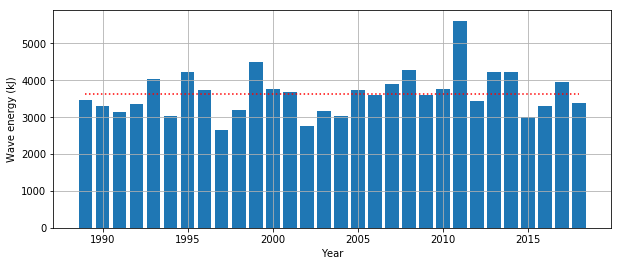

In [39]:
plt.figure(figsize=(10,4))
plt.bar(range(1989,2019),tableEyearly['Energy'])
plt.plot([1989, 2018], [Eyr_avg, Eyr_avg], 'r:')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Wave energy (kJ)')
plt.savefig('avg_yearly_energy.png')

## Long-term monthly averaging

In [8]:
tableE12months = pd.pivot_table(table, index=['month'], values='Energy', aggfunc=np.average)
tableE12months

,Energy
month,
1,6686.826853
2,4416.353370
3,2741.940330
4,1325.458812
5,1032.866062
6,1267.094837
7,1336.592130
8,1510.990372
9,1386.029451


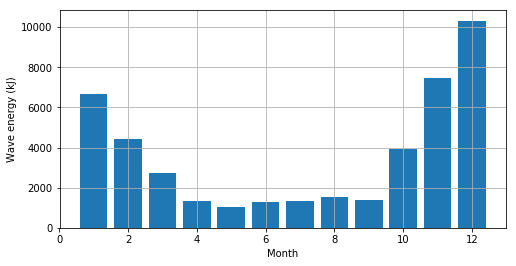

In [25]:
plt.figure(figsize=(8,4))
plt.bar(range(1,13),tableE12months['Energy'])
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Wave energy (kJ)')
plt.savefig('avg_monthly_energy.png')

In [34]:
table.to_excel('wave_Tien_Chau.xlsx')

## Wave roses

_Note_: the library `windrose` must be installed by using e.g. `pip` or `conda`.

Text(0, 22, '*')

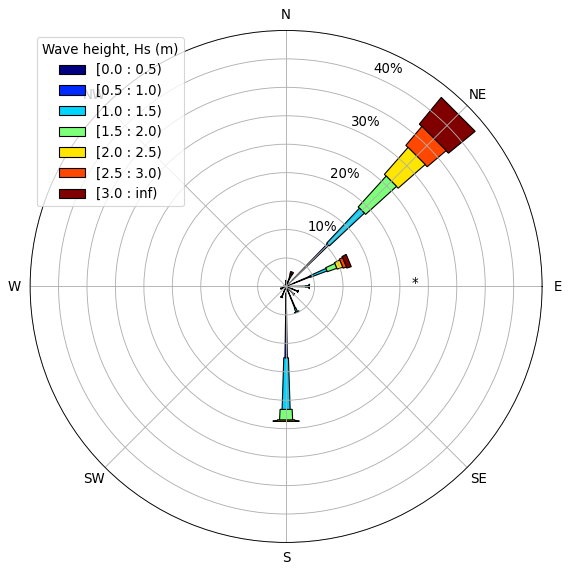

In [8]:
from windrose import WindroseAxes
plt.rcParams.update({'font.size': 12})

ax = WindroseAxes.from_ax()
ax.box(table['Dir'], table['Hs'], normed=True, bins=np.arange(0, 3.1, 0.5), edgecolor='k')

ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])

ax.set_ylim([0, 35])
ax.set_yticks(np.arange(0, 46, 5))
ax.set_yticklabels(
    ['', r'', r'10%', r'', r'20%', r'', r'30%', r'', r'40%', r''])

ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Wave height, Hs (m)')

# Annotate the two characteristic groups:
# Group 1: NE waves, Hs = 2 m, θ ≈  52°, freq 63%.
# Group 2:  S waves, Hs = 1 m, θ ≈ 177°, freq 34%.
# Threshold:                   θ ≈ 101°.
ax.annotate('', xy=(0,22))

# plt.savefig('YearlyWaverose.png')

In [6]:
ax.annotate('*', (0,22))
plt.show()

In [13]:
# tableMo contains monthly wave data
# for convenience, index 0 is None, index 1 is Jan, etc.
tableMo = [None] * 13

for month_index in range(1, 13):
    tableMo[month_index] = table[table['month']==month_index]
# tableJan = table[table['month']==1]
# tableFeb = table[table['month']==2]
# tableMar = table[table['month']==3]
# tableApr = table[table['month']==4]
# tableMay = table[table['month']==5]
# tableJun = table[table['month']==6]
# tableJul = table[table['month']==7]
# tableAug = table[table['month']==8]
# tableSep = table[table['month']==9]
# tableOct = table[table['month']==10]
# tableNov = table[table['month']==11]
# tableDec = table[table['month']==12]

Plotting wave roses for each month:

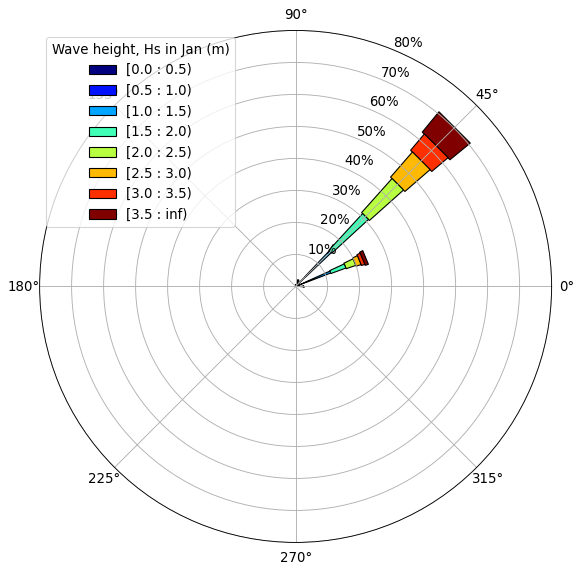

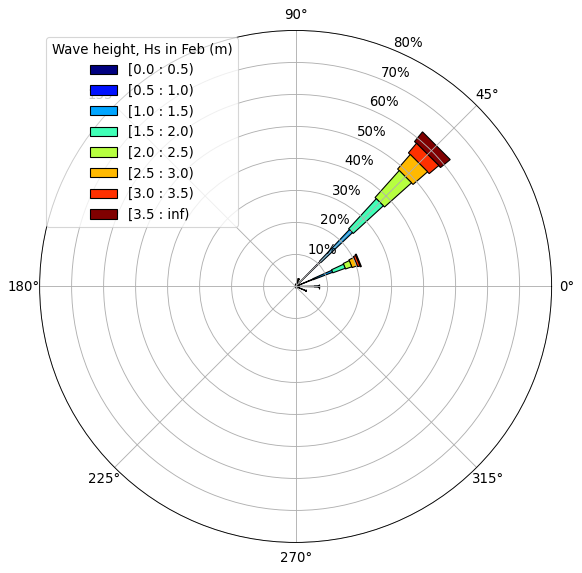

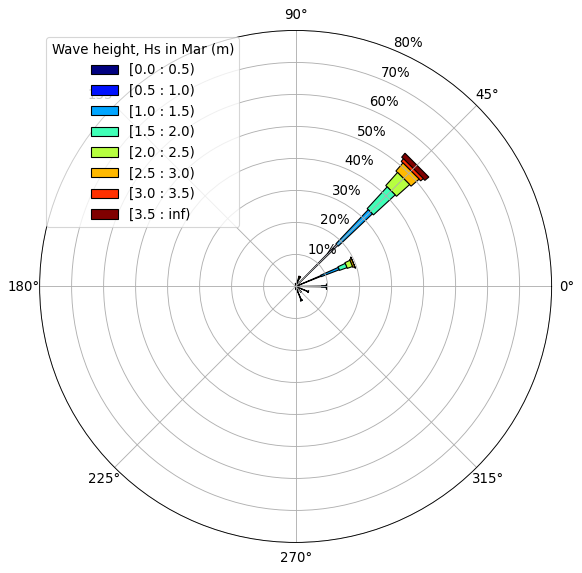

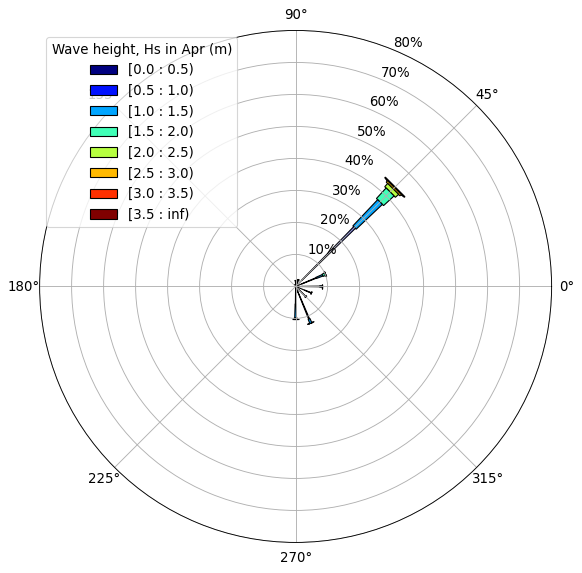

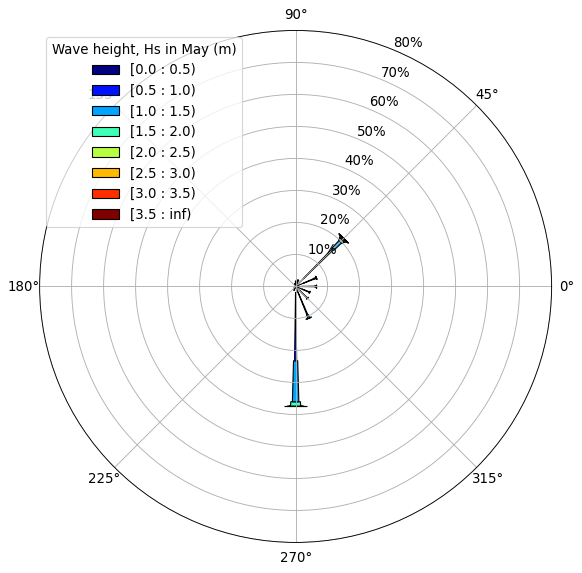

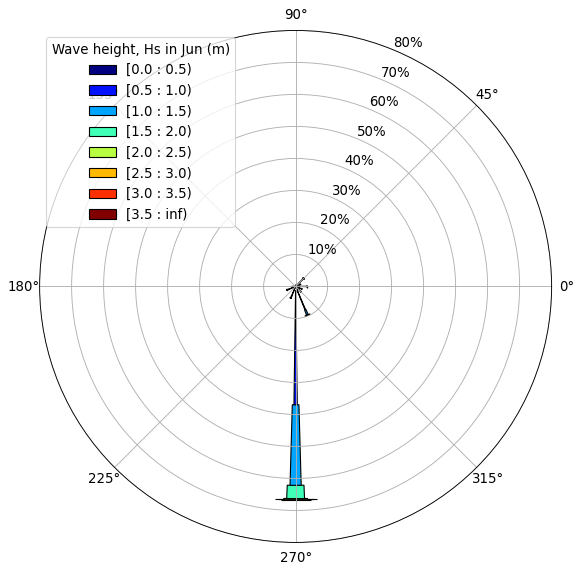

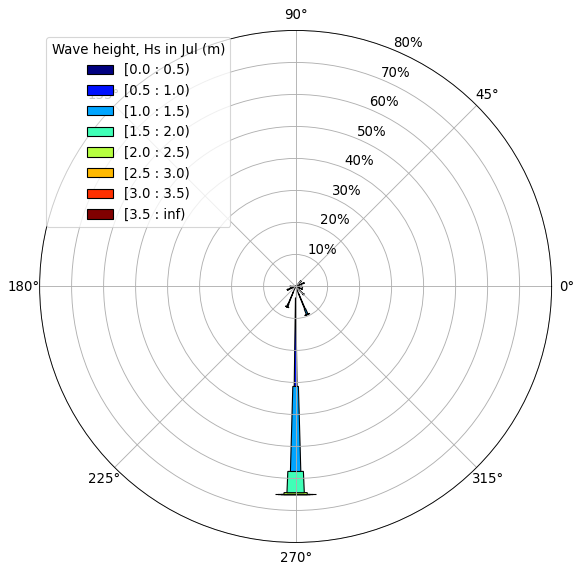

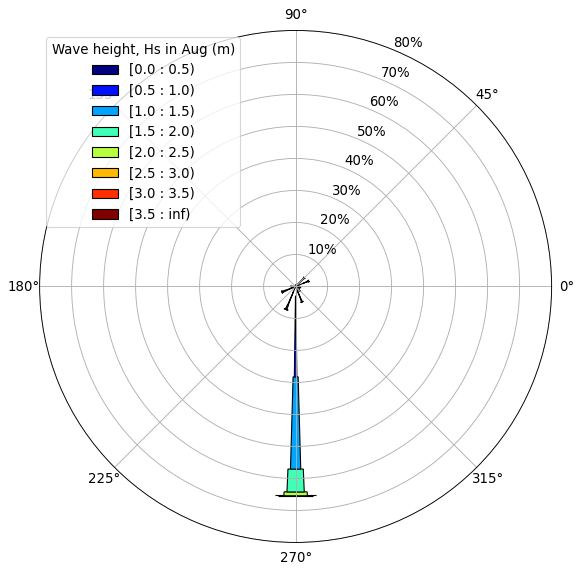

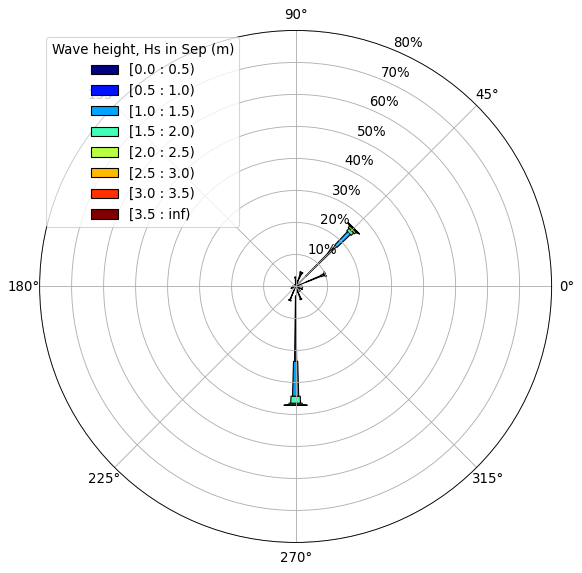

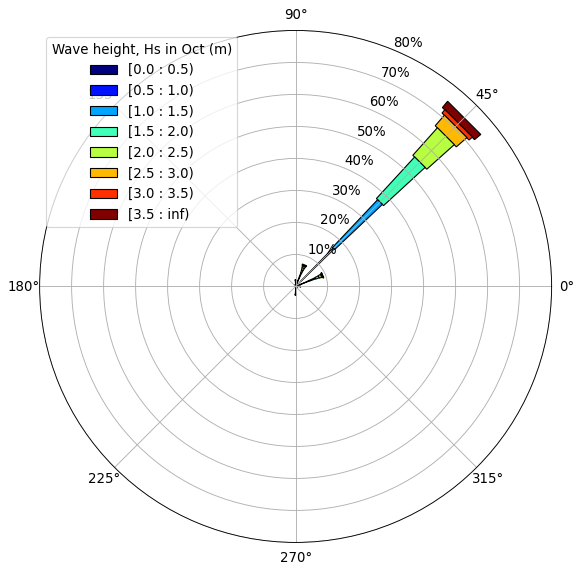

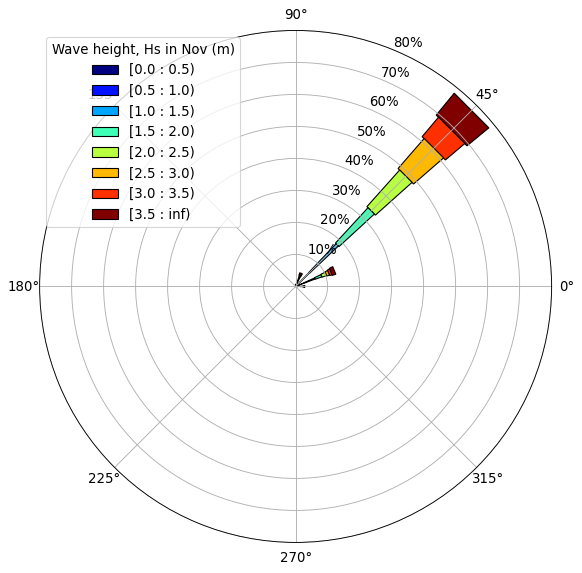

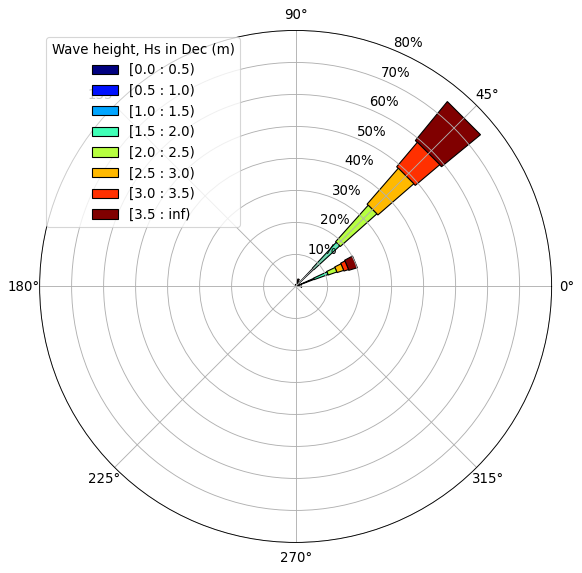

In [14]:
month_names = [None, 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month_index in range(1, 13):
    ax = WindroseAxes.from_ax()
    ax.box(tableMo[month_index]['Dir'], tableMo[month_index]['Hs'],
           normed=True, bins=np.arange(0, 3.6, 0.5), edgecolor='k')
    ax.set_ylim([0, 80])
    ax.set_yticks(np.arange(0, 81, 10))
    ax.set_yticklabels(
        ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
    ax.set_legend()
    legend = ax.legend(
        loc=2,
        ncol=1,
        bbox_to_anchor=(0, 0, 1, 1),
        prop={'size': 12},
        fancybox=True,
        shadow=False,
        title='Wave height, Hs in %s (m)' % month_names[month_index])

    plt.savefig('waverose_%s.png' % month_names[month_index])

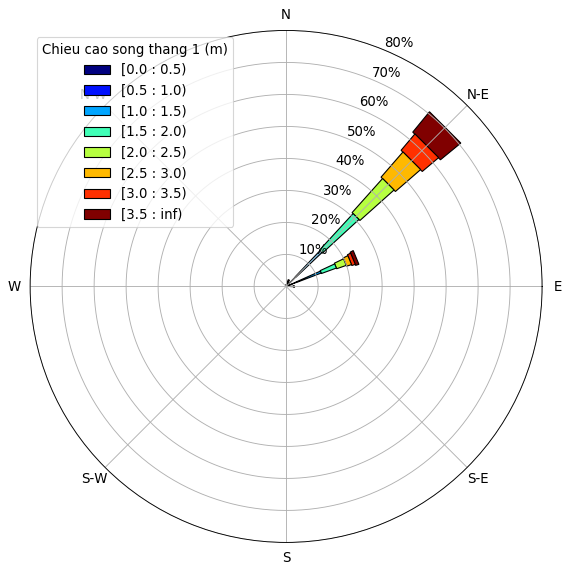

In [ ]:
ax = WindroseAxes.from_ax()
ax.box(tableJan['Dir'], tableJan['Hs'], normed=True, bins=np.arange(0, 3.6, 0.5), edgecolor='k')
ax.set_ylim([0, 80])
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 1 (m)')

plt.savefig('JanWaverose.png')

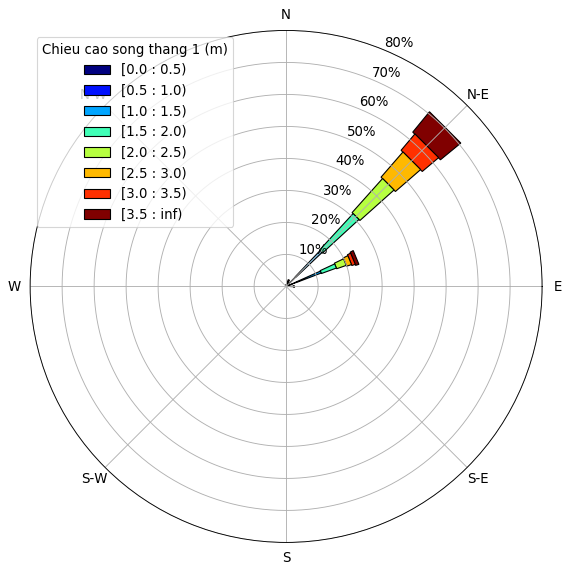

In [ ]:
ax = WindroseAxes.from_ax()
ax.box(tableJan['Dir'], tableJan['Hs'], normed=True, bins=np.arange(0, 3.6, 0.5), edgecolor='k')
ax.set_ylim([0, 80])
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 1 (m)')

plt.savefig('JanWaverose.png')

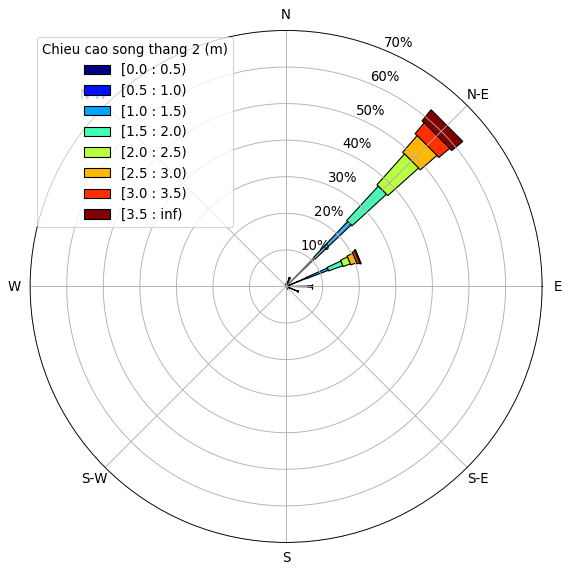

In [38]:
ax = WindroseAxes.from_ax()
ax.box(tableFeb['Dir'], tableFeb['Hs'], normed=True, bins=np.arange(0, 3.6, 0.5), edgecolor='k')
ax.set_ylim([0, 70])
ax.set_yticks(np.arange(0, 71, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 2 (m)')

plt.savefig('FebWaverose.png')

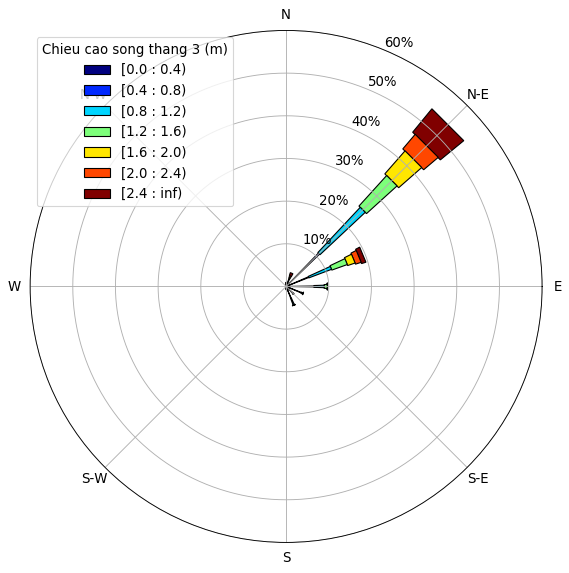

In [43]:
ax = WindroseAxes.from_ax()
ax.box(tableMar['Dir'], tableMar['Hs'], normed=True, bins=np.arange(0, 2.5, 0.4), edgecolor='k')
ax.set_ylim([0, 60])
ax.set_yticks(np.arange(0, 61, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 3 (m)')

plt.savefig('MarWaverose.png')

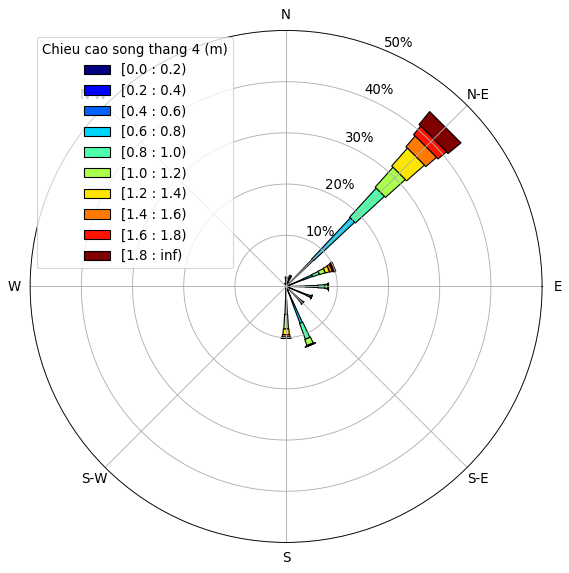

In [66]:
ax = WindroseAxes.from_ax()
ax.box(tableApr['Dir'], tableApr['Hs'], normed=True, bins=np.arange(0, 1.9, 0.2), edgecolor='k')
ax.set_ylim([0, 50])
ax.set_yticks(np.arange(0, 51, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 4 (m)')

plt.savefig('AprWaverose.png')

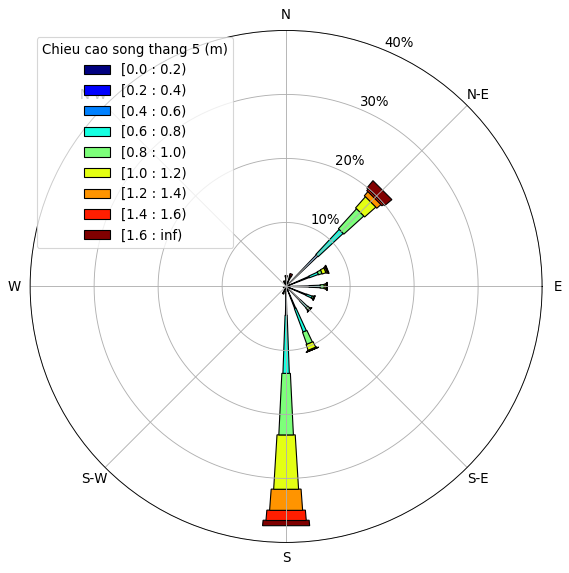

In [57]:
ax = WindroseAxes.from_ax()
ax.box(tableMay['Dir'], tableMay['Hs'], normed=True, bins=np.arange(0, 1.7, 0.2), edgecolor='k')
ax.set_ylim([0, 40])
ax.set_yticks(np.arange(0, 41, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 5 (m)')

plt.savefig('MayWaverose.png')

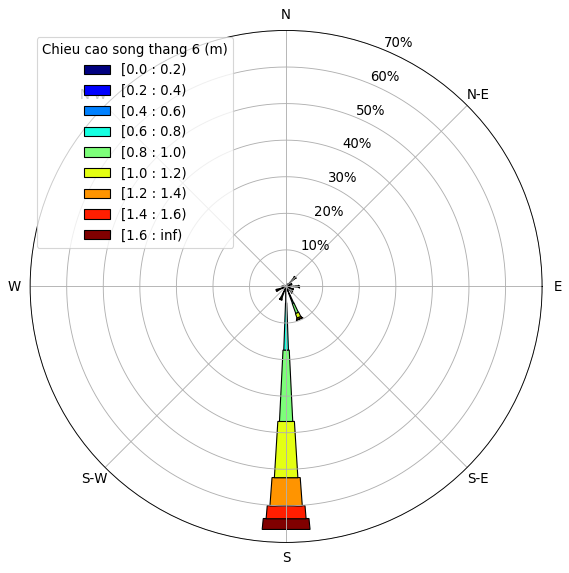

In [62]:
ax = WindroseAxes.from_ax()
ax.box(tableJun['Dir'], tableJun['Hs'], normed=True, bins=np.arange(0, 1.7, 0.2), edgecolor='k')
ax.set_ylim([0, 70])
ax.set_yticks(np.arange(0, 71, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 6 (m)')

plt.savefig('JunWaverose.png')

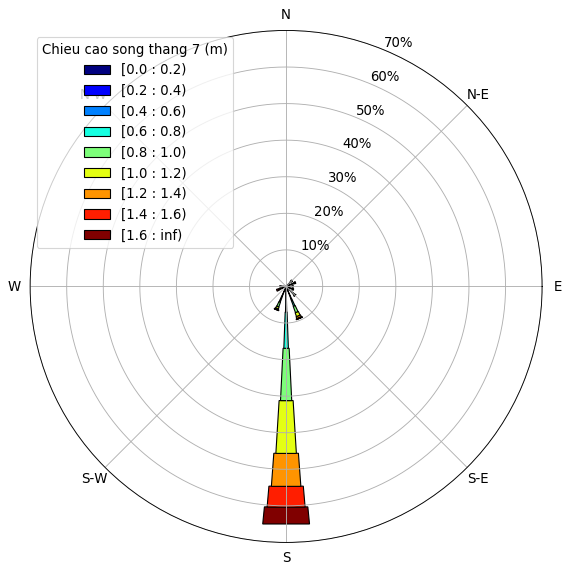

In [67]:
ax = WindroseAxes.from_ax()
ax.box(tableJul['Dir'], tableJul['Hs'], normed=True, bins=np.arange(0, 1.7, 0.2), edgecolor='k')
ax.set_ylim([0, 70])
ax.set_yticks(np.arange(0, 71, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 7 (m)')

plt.savefig('JulWaverose.png')

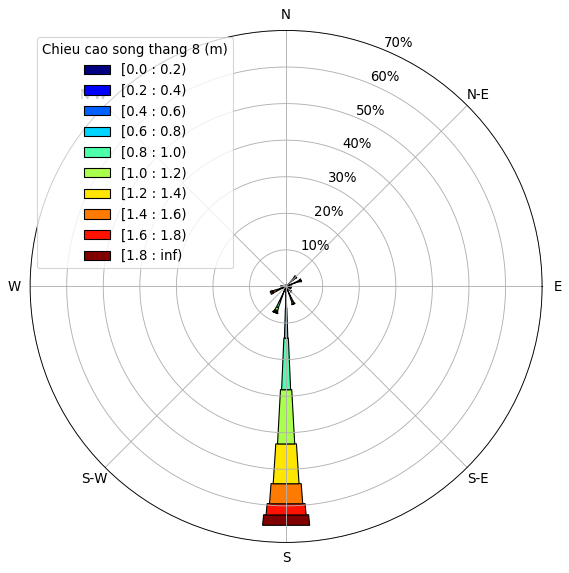

In [69]:
ax = WindroseAxes.from_ax()
ax.box(tableAug['Dir'], tableAug['Hs'], normed=True, bins=np.arange(0, 1.9, 0.2), edgecolor='k')
ax.set_ylim([0, 70])
ax.set_yticks(np.arange(0, 71, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 8 (m)')

plt.savefig('AugWaverose.png')

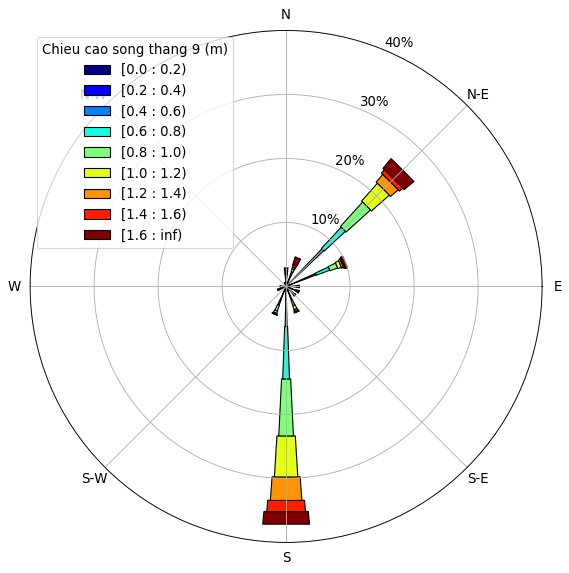

In [73]:
ax = WindroseAxes.from_ax()
ax.box(tableSep['Dir'], tableSep['Hs'], normed=True, bins=np.arange(0, 1.7, 0.2), edgecolor='k')
ax.set_ylim([0, 40])
ax.set_yticks(np.arange(0, 41, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 9 (m)')

plt.savefig('SepWaverose.png')

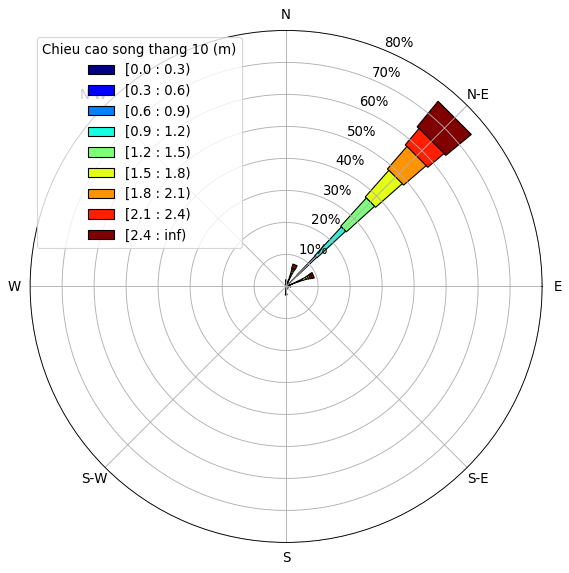

In [77]:
ax = WindroseAxes.from_ax()
ax.box(tableOct['Dir'], tableOct['Hs'], normed=True, bins=np.arange(0, 2.5, 0.3), edgecolor='k')
ax.set_ylim([0, 80])
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 10 (m)')

plt.savefig('OctWaverose.png')

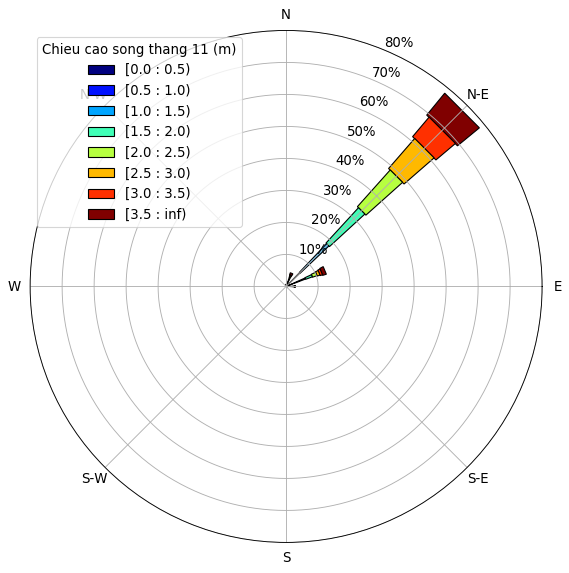

In [81]:
ax = WindroseAxes.from_ax()
ax.box(tableNov['Dir'], tableNov['Hs'], normed=True, bins=np.arange(0, 3.6, 0.5), edgecolor='k')
ax.set_ylim([0, 80])
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 11 (m)')

plt.savefig('NovWaverose.png')

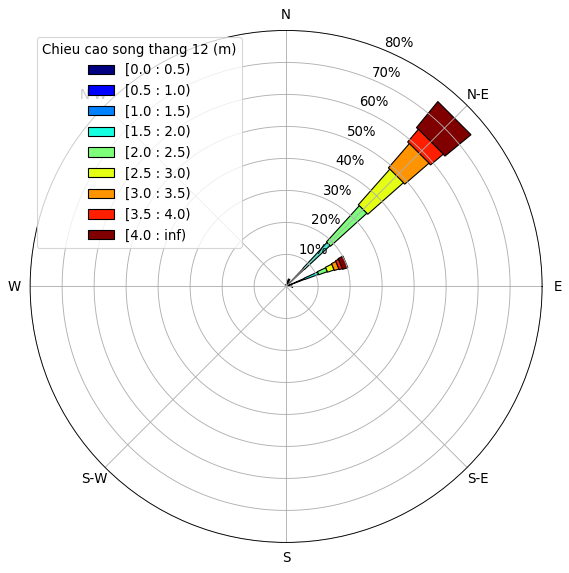

In [83]:
ax = WindroseAxes.from_ax()
ax.box(tableDec['Dir'], tableDec['Hs'], normed=True, bins=np.arange(0, 4.1, 0.5), edgecolor='k')
ax.set_ylim([0, 80])
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(
    ['',r'10%', r'20%', r'30%', r'40%', r'50%', r'60%', r'70%', r'80%'])
ax.set_legend()
legend = ax.legend(
    loc=2,
    ncol=1,
    bbox_to_anchor=(0, 0, 1, 1),
    prop={'size': 12},
    fancybox=True,
    shadow=False,
    title='Chieu cao song thang 12 (m)')

plt.savefig('DecWaverose.png')